In [1]:
import numpy as np
import jax.numpy as jnp
from jax import jit

In [2]:
# Build a toy discriminant

obs_sig = np.random.normal(loc=1.5, scale=0.5, size=2000)
obs_bkg = np.random.normal(loc=1.0, scale=0.5, size=5000)

In [3]:
xmin = np.amin(obs_bkg)
xmax = np.amax(obs_sig)

bins = np.linspace(xmin, xmax, num=7)

hist_sig, _ = np.histogram(obs_sig, bins)
hist_bkg, _ = np.histogram(obs_bkg, bins)

In [4]:
print(hist_sig)
print(hist_bkg)

[  1  75 491 918 457  58]
[  90  839 2329 1503  232    7]


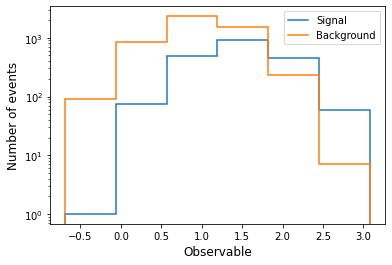

In [5]:
import mplhep as hep
from matplotlib import pyplot as plt

hep.histplot(hist_sig, bins, label='Signal')
hep.histplot(hist_bkg, bins, label='Background')

plt.xlabel('Observable', size=12)
plt.ylabel('Number of events', size=12)
plt.legend(loc='upper right')
plt.yscale('log')

In [37]:
# Build test statistic

# Calculate the overall yield based on the value of signal strength mu

def sigma(mu, hist_sig, hist_bkg):
    
    sigma_mu_binned = mu*hist_sig+hist_bkg  
                        
    return sigma_mu_binned


In [8]:
print(sigma(1.0, hist_sig, hist_bkg))

[  91.  914. 2820. 2421.  689.   65.]


In [12]:
N_obs_Asimov = hist_sig + hist_bkg
print(N_obs_Asimov.shape)
print(hist_sig.shape)
print(hist_bkg.shape)

(6,)
(6,)
(6,)


In [38]:
def NLL(mu, hist_sig, hist_bkg, N_obs_Asimov):
    
    sigma_mu = sigma(mu, hist_sig, hist_bkg)

    llr = jnp.array([-2*N_obs_Asimov*jnp.log(sigma_mu)+2*sigma_mu]).sum()
    
    return llr


In [39]:
print( NLL( 1.01, hist_sig, hist_bkg, N_obs_Asimov ) - NLL( 1.0, hist_sig, hist_bkg, N_obs_Asimov ) )

0.0859375


In [40]:
def NLL_minuit(mu):
    
    return NLL(mu, hist_sig, hist_bkg, N_obs_Asimov)

In [22]:
from iminuit import Minuit
from jax import grad

m1 = Minuit(jit(NLL_minuit), jnp.array([1.0]), grad=jit(grad(NLL_minuit)))
m1.errordef = Minuit.LEAST_SQUARES
#m1.precision = 1e-7
m1.strategy = 2
m1.migrad()
m1.minos()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -9.137e+04                 │              Nfcn = 41               │
│ EDM = 0.00035 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu   │   1.000   │   0.035   │   -0.035   │   0.036    │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┐
│          │          mu           │
├──────────┼───────────┬───────────┤
│  Error   │  -0.035   │   0.036   │
│  Valid   │   True    │   True    │
│ At Limit │   False   │   False   │
│ Max FCN  │   False   │   False   │
│ New Min  │   False   │   False   │
└──────────┴───────────┴───────────┘
┌────┬─────────┐
│    │      mu │
├────┼─────────┤
│ mu │ 0.00125 │
└────┴─────────┘

In [23]:
# We can get the best-fit values straight from iMinuit!

print("Maximum Likelihood Estimate for POI : "+str(np.array(m1.values)))
print(f"Error estimates for POI : "+str(np.array(m1.errors)))

Maximum Likelihood Estimate for POI : [1.]
Error estimates for POI : [0.03540399]


In [41]:
%%timeit

m1 = Minuit(NLL_minuit, jnp.array([1.0]), grad=grad(NLL_minuit))
m1.errordef = Minuit.LEAST_SQUARES
m1.strategy = 2
m1.migrad()

18.1 ms ± 230 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [42]:
%%timeit

m1 = Minuit(jit(NLL_minuit), jnp.array([1.0]), grad=jit(grad(NLL_minuit)))
m1.errordef = Minuit.LEAST_SQUARES
m1.strategy = 2
m1.migrad()

1.28 ms ± 13.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Text(0.5, 1.0, '')

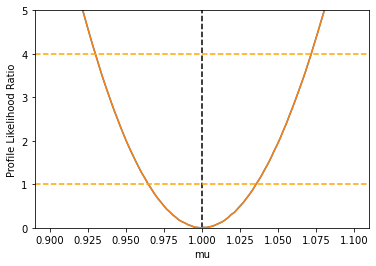

In [43]:
bins, values = m1.draw_mnprofile('mu', bound=(0.9,1.1), size=100, subtract_min=True, band=False)

plt.plot(bins, values)
plt.axis(ymax=5.0, ymin=0.0)
plt.ylabel('Profile Likelihood Ratio')
plt.axhline(y = 1.0, color = 'orange', linestyle = '--')
plt.axhline(y = 4.0, color = 'orange', linestyle = '--')
plt.title('')

In [52]:

#from jax.config import config
#config.update("jax_debug_nans", True)

@jit
def poly_interp(tuple_input):
    
    alpha, varUp, varDown, varNom = tuple_input
    
    pow_up = jnp.divide(varUp,varNom)
    pow_down = jnp.divide(varDown,varNom)
    logHi = jnp.log(jnp.clip(pow_up,1e-7,None))
    logLo = jnp.log(jnp.clip(pow_down,1e-7,None))
    logHi = jnp.log(pow_up)
    logLo = jnp.log(pow_down)
    pow_up_log = jnp.multiply(pow_up,logHi)
    pow_down_log = -jnp.multiply(pow_down,logLo)
    pow_up_log2 = jnp.multiply(pow_up_log,logHi)
    pow_down_log2 = -jnp.multiply(pow_down_log,logLo)
    
    S0 = (pow_up+pow_down)/2.0
    A0 = (pow_up-pow_down)/2.0
    S1 = (pow_up_log+pow_down_log)/2.0
    A1 = (pow_up_log-pow_down_log)/2.0
    S2 = (pow_up_log2+pow_down_log2)/2.0
    A2 = (pow_up_log2-pow_down_log2)/2.0
 
    a1 = (15*A0-7*S1+A2)/8.0
    a2 = (-24+24*S0-9*A1+S2)/8.0
    a3 = (-5*A0+5*S1-A2)/4.0
    a4 = (12-12*S0+7*A1-S2)/4.0
    a5 = (3*A0-3*S1+A2)/8.0
    a6 = (-8+8*S0-5*A1+S2)/8.0

    return 1.0 + alpha * (a1 + alpha * ( a2 + alpha * ( a3 + alpha * ( a4 + alpha * ( a5 + alpha * a6 ) ) ) ) )
    

@jit
def exp_interp(tuple_input):
    
    alpha, varUp, varDown, varNom = tuple_input
    
    return jnp.where(alpha>1.0, (varUp/varNom)**alpha, (varDown/varNom)**(-alpha))


@jit
def lin_interp(alpha, varUp, varDown):
    
    return jnp.where(alpha>=0.0, (alpha*(varUp-1)), (alpha*(varDown-1)))

@jit
def sigma(mu, hist_sig, hist_bkg, fact_sig, fact_big):
    
    sigma_mu_binned = mu*hist_sig*fact_sig + hist_bkg*fact_big
                        
    return sigma_mu_binned


In [94]:
NP_size = 10

param_array = [0.0] * (NP_size+1)

param_array[0] = 1.0 
param_array = jnp.array(param_array, dtype='float32')

arr_ratio_up_sig = jnp.abs(np.random.normal(1.0, 0.5, NP_size))
arr_ratio_down_sig = 2.0 - arr_ratio_up_sig

arr_ratio_up_bkg = jnp.abs(np.random.normal(1.0, 0.5, NP_size))
arr_ratio_down_bkg = 2.0 - arr_ratio_up_bkg


In [95]:
print(arr_ratio_up_sig)

[1.6450629  0.9622708  0.47937047 0.52829546 0.87267655 1.4509971
 0.7174294  0.7585183  1.5117334  1.2986413 ]


In [123]:
import jax

@jit
def NLL(param_array, hist_sig, hist_bkg, N_obs_Asimov, arr_ratio_up_sig, arr_ratio_down_sig, arr_ratio_up_bkg, arr_ratio_down_bkg):
    
    mu = param_array.at[0]
        
    def syst_update(n, carry):
        
        fact_sig, fact_bkg = carry

        fact_sig *= jax.lax.cond(jnp.abs(param_array.at[n])<=1.0, poly_interp, exp_interp, (param_array.at[n], arr_ratio_up_sig.at[n-1], arr_ratio_down_sig.at[n-1], 1.0))

        fact_bkg *= jax.lax.cond(jnp.abs(param_array.at[n])<=1.0, poly_interp, exp_interp, (param_array.at[n], arr_ratio_up_bkg.at[n-1], arr_ratio_down_bkg.at[n-1], 1.0))
        
        return (fact_sig, fact_bkg)
        
    fact_sig, fact_bkg = jax.lax.fori_loop(1, len(param_array), syst_update, jnp.ones(2))
    
    sigma_mu = sigma(mu, hist_sig, hist_bkg, fact_sig, fact_big)

    llr = jnp.array([-2*N_obs_Asimov*jnp.log(sigma_mu)+2*sigma_mu]).sum()    
    
    return llr
    

In [124]:
print(jnp.ones(2))

[1. 1.]


In [125]:
print(NLL(param_array, hist_sig, hist_bkg, N_obs_Asimov, 
          arr_ratio_up_sig, arr_ratio_down_sig, arr_ratio_up_bkg, arr_ratio_down_bkg))

TypeError: Argument '_IndexUpdateRef(Traced<ShapedArray(float32[11])>with<DynamicJaxprTrace(level=0/1)>, Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=1/1)>)' of type <class 'jax._src.numpy.lax_numpy._IndexUpdateRef'> is not a valid JAX type.

In [58]:
@jit
def NLL_minuit(mu):
    
    return NLL(mu, hist_sig, hist_bkg, N_obs_Asimov)

In [56]:
from iminuit import Minuit
from jax import grad

m1 = Minuit(jit(NLL_minuit), param_array, grad=jit(grad(NLL_minuit)))
m1.errordef = Minuit.LEAST_SQUARES
#m1.precision = 1e-7
m1.strategy = 2
m1.migrad()
m1.minos()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()